In [1]:
import numpy as np
from scipy import interp
import glob
import networkx as nx
import re
import graspy
from graspy.embed import OmnibusEmbed
from graspy.embed import ClassicalMDS
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, roc_curve, auc
import matplotlib.pyplot as plt
from graspy.plot import pairplot
%matplotlib inline

Import modules

In [2]:
# functions
def isolate_number_in_the_filename(file):
    subject_info = re.findall(r'\d+', file)
    return subject_info[0]


def query_columns(df, subid):
    subid = subid[2:]
    age = df.query('SUBID == {}'.format(subid))['AGE_AT_SCAN_1'].tolist()[0]
    sex = df.query('SUBID == {}'.format(subid))['SEX'].tolist()[0]
    return age, sex


def save_patients_data(ids, ages, sexes):
    # Create pandas dataframe from lists using dictionary
    d = {'ID': ids, 'Age': ages, 'Sex': sexes}
    patient_data = pd.DataFrame(d)
    return patient_data

isolate_number_in_the_filename: get the 7-figure number from data
query_columns: match the 7-figure number with the SUBID of each patient first and then get matched age and sex
save_patients_data: Create pandas dataframe from lists using dictionary

In [3]:
df = pd.read_csv("/Users/zhangsiqi/Downloads/HNU1.csv")
allLines = []
ids = []
ages = []
sexes = []

Use pandas to read csv file
Create lists
allLines is a list of graphs

In [4]:
for file in glob.glob("/Users/zhangsiqi/Desktop/brain/*.ssv"):
    # Isolate 7 digit number in the filename
    # Look string manipulation in python
    subid = isolate_number_in_the_filename(file)
    # Use the id to the patient's sex and age from df
    # Look up how to query tables in pandas
    age, sex = query_columns(df, subid)
    # Save values for age and sex
    # Save the values in a pandas dataframe
    # Store patient id, age, and sex
    ages.append(age)
    ids.append(subid)
    sexes.append(sex)
    # Read files
    G = nx.read_weighted_edgelist(file)
    allLines.append(G)

Read every file from the folder named brain in a loop
Append age, subid and sex in the end of lists
Use networkx to read graphs
Append each graph in the end of list allLines

In [5]:
patient_data = save_patients_data(ids, ages, sexes)

Create dataframes

In [6]:
# embedding multiple graphs
embedder = OmnibusEmbed()
Zhat = embedder.fit_transform(allLines)

Embedding multiple graphs using omnibus embedding

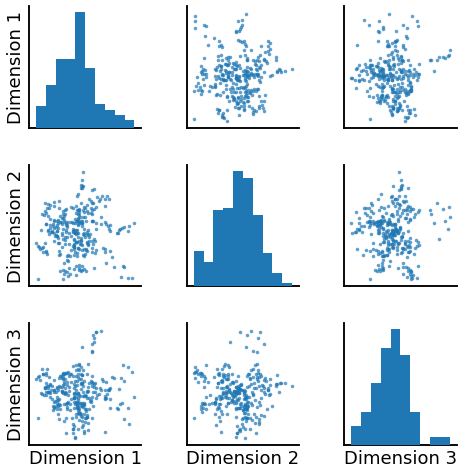

In [7]:
cmds = ClassicalMDS()
cmds_embedding = cmds.fit_transform(Zhat)
plot = pairplot(cmds_embedding)
plt.show()

Find similarity between latent positions

In [8]:
cmds_df = pd.DataFrame(cmds_embedding, columns=["Dimension {}".format(i) for i in range(cmds_embedding.shape[1])])
cmds_df.head(10)

,Dimension 0,Dimension 1,Dimension 2
0,-15.617064,-24.233845,-7.788965
1,-1.999253,-44.630275,-5.027785
2,-32.924351,-51.079627,26.243356
3,-8.842550,1.178060,22.066516
4,103.371713,-45.793887,19.831237
5,-80.072172,1.527916,1.372814
6,20.170635,-31.474061,-27.115684
7,4.164592,17.100722,25.037809
8,-30.352218,28.985466,26.121972
9,28.417959,-14.568522,-6.390384


Use pandas to create dataframe 

In [9]:
# Features
X = cmds_embedding

# Label
y = patient_data['ID']
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print("Accuracy of ID:", metrics.accuracy_score(y_test, y_pred))

Accuracy of ID: 0.7666666666666667
Accuracy of ID: 0.7333333333333333
Accuracy of ID: 0.5333333333333333
Accuracy of ID: 0.8
Accuracy of ID: 0.6666666666666666
Accuracy of ID: 0.7666666666666667
Accuracy of ID: 0.7333333333333333
Accuracy of ID: 0.8666666666666667
Accuracy of ID: 0.7
Accuracy of ID: 0.6666666666666666


First separate the columns into dependent and independent variables (or features and labels)
Then split those variables into a training and test set
Next, train the model on the training set and perform predictions on the test set
After training, check the accuracy using actual and predicted values.
@Preidct ID

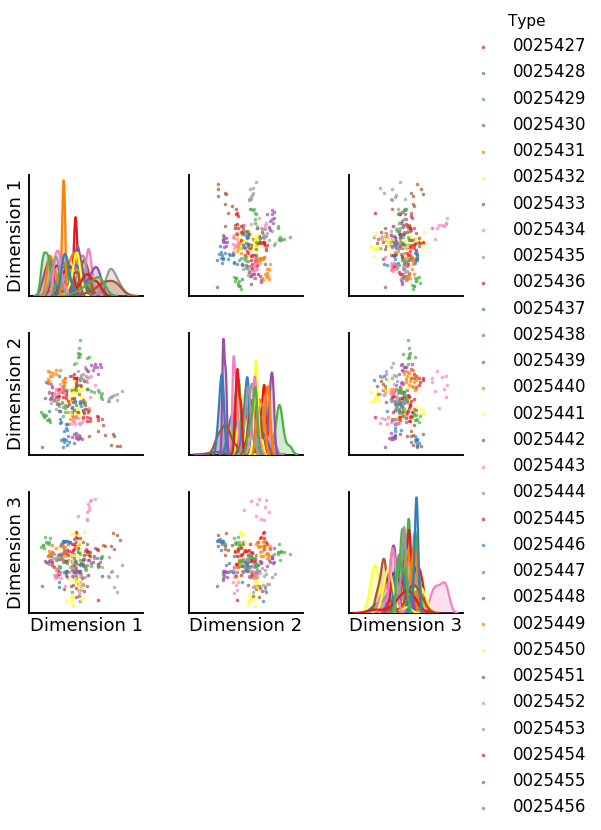

In [10]:
plot = pairplot(X, labels=y.tolist())

/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/Users/zhangsiqi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel()

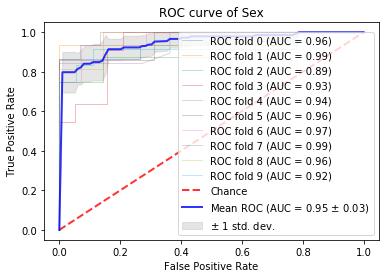

In [29]:
X = cmds_embedding
y = patient_data['Sex']
kf = KFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

i = 0
for train, test in kf.split(X):
    clf = RandomForestClassifier(n_estimators=150)
    clf = clf.fit(X[train], y[train])
    probas_ = clf.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:,1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Sex')
plt.legend(loc="lower right")
plt.show()
 

In [12]:
X = cmds_embedding
y = patient_data['Sex']
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy of Sex:", metrics.accuracy_score(y_test, y_pred))

Accuracy of Sex: 0.8666666666666667
Accuracy of Sex: 0.9666666666666667
Accuracy of Sex: 0.9
Accuracy of Sex: 0.8333333333333334
Accuracy of Sex: 0.8
Accuracy of Sex: 0.9
Accuracy of Sex: 0.8333333333333334
Accuracy of Sex: 0.9
Accuracy of Sex: 0.9
Accuracy of Sex: 0.8666666666666667


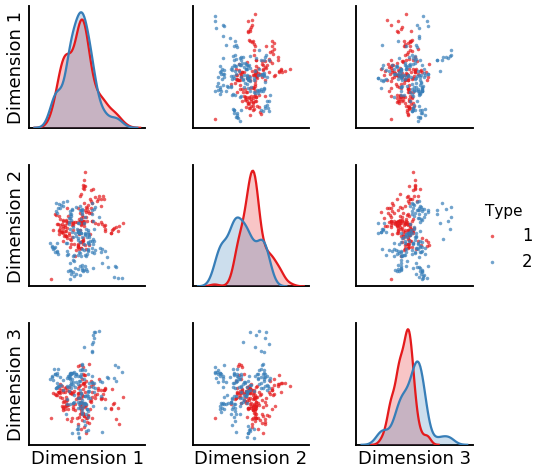

In [13]:
plot = pairplot(X, labels=y.tolist())

### Make a plot

1. scatterplot of cmds embedding for testing data
2. overlay the predicted labels for sex

@Predict Sex

In [16]:
X = cmds_embedding
y = patient_data['Age']
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestRegressor(n_estimators=150)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy of Age:", r2_score(y_test, y_pred))

Accuracy of Age: 0.4152788700564971
Accuracy of Age: 0.23360034904013993
Accuracy of Age: 0.36180787559568606
Accuracy of Age: 0.6447921011058453
Accuracy of Age: 0.14948412344578188
Accuracy of Age: 0.42072798216276486
Accuracy of Age: 0.5194749322493226
Accuracy of Age: 0.7191802290536468
Accuracy of Age: 0.33692761299435003
Accuracy of Age: 0.1111111111111115


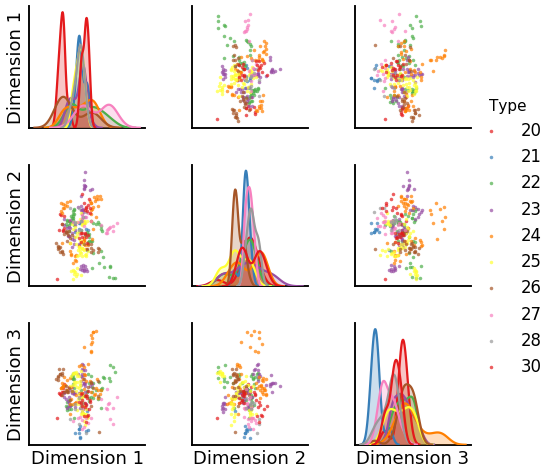

In [17]:
plot = pairplot(X, labels=y.tolist())